# Import libraries and modules

In [21]:
# Reload modules before executing user code
%load_ext autoreload
%autoreload 2

import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from scipy.io import loadmat
import warnings
from contextlib import contextmanager
from copy import copy
from scipy.linalg import LinAlgWarning
from sklearn.exceptions import ConvergenceWarning

# Find current directory
current_dir = os.getcwd()
# Find root directory
root_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
# Add root directory to path
sys.path.append(root_dir)

print(f"Current directory: {current_dir}")
print(f"Root directory: {root_dir}")

import pysindy.pysindy as ps
from pysindy.differentiation import SmoothedFiniteDifference

from ck_utils import ck_constraints, extract_and_save_k_values

# ignore user warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

np.random.seed(1000)  # Seed for reproducibility

# Integrator keywords for solve_ivp
integrator_keywords = {}
integrator_keywords['method'] = 'RK23'   #'LSODA'
integrator_keywords['rtol'] = 1.0  # 1e-3
integrator_keywords['atol'] = 1.0  # 1e-4
integrator_keywords['max_step'] = 0.1
integrator_keywords['h_factor'] = 1

system_size = 10
n_samples_train = 10000
n_samples_test = 500

poly_order = 2
threshold = 0
dt = 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Current directory: /u1/ame805/pysindy_fork/simlab_experiments
Root directory: /u1/ame805/pysindy_fork


# Functions

In [22]:
def readExpData(file_path, Nsize=100):
    
    if os.path.isfile(file_path):
        
        # extract data from file using numpy module
        data = np.loadtxt(file_path)
        size = np.shape(data)

        t_data = np.empty(shape=(size[0],))
        # first column of the file is time
        t_data[:] = data[:, 0]

        # remaining data is number of clusters of size n. Index for column i corresponds to number of clusters of size i-1
        # n_data = data[:, 1:Nsize+1]
        #** We just divide the cluster numbers by the volume of the system which is 126^3 (in units of sigma). 
        n_data = data[:, 1:Nsize+1] / (126**3)  ## only the first 'size' (excluding the very first 0) entries to match the kappa coeff
        
        return t_data, n_data
    
    else:
        print(f"Experiment file ({file_path}) does not exist")
        exit()

@contextmanager
def ignore_specific_warnings():
    filters = copy(warnings.filters)
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    warnings.filterwarnings("ignore", category=LinAlgWarning)
    warnings.filterwarnings("ignore", category=UserWarning)
    yield
    warnings.filters = filters

# Load data

In [23]:
experiment_dir = 'data'
experiment_file = 'Population_Training_Results.dat'
exp_dir = os.path.join(experiment_dir, experiment_file)

t_values, N_clusters = readExpData(exp_dir, Nsize=system_size)

# # n_samples_train random indices
# indices = np.random.choice(len(t_values), n_samples_train, replace=False)
# indices = np.sort(indices)
# Linearly spaced indices
indices = np.linspace(0, len(t_values)-1, n_samples_train, dtype=int)
N_clusters_train = N_clusters[indices]
t_values_train = t_values[indices]

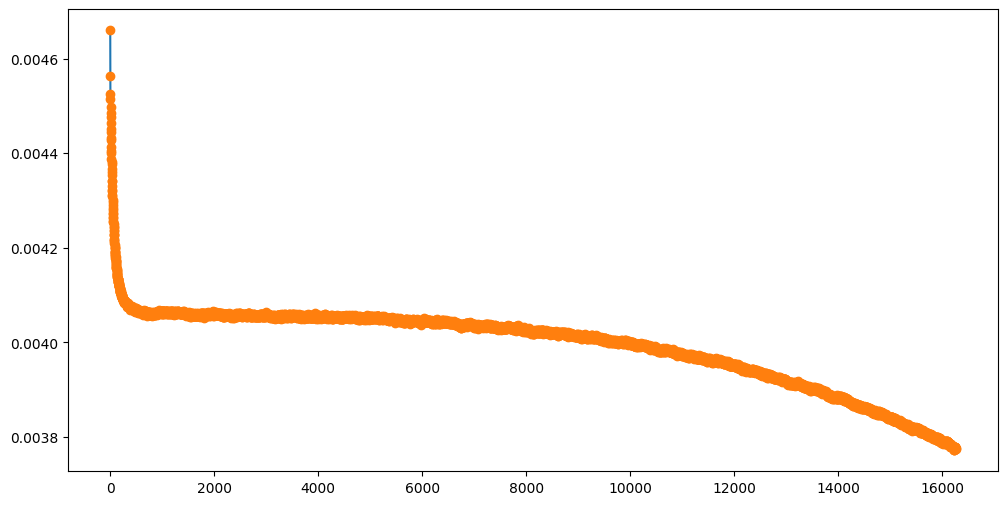

In [24]:
n_to_plot = 1

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(t_values, N_clusters[:, n_to_plot-1], label=f'Cluster size {n_to_plot}')
# plt.plot(t_values[:n_samples_train], N_clusters[:n_samples_train, n_to_plot-1], label=f'Cluster size {n_to_plot}')
plt.plot(t_values_train, N_clusters_train[:, n_to_plot-1], 'o', label=f'Training data Cluster size {n_to_plot}')

plt.show()

# Prepare the model (add constraints)

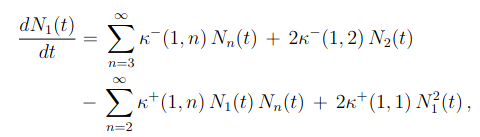

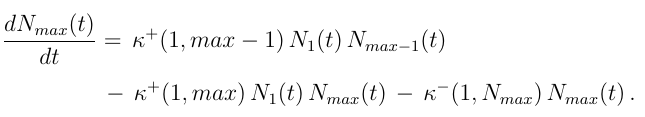

In [25]:
# Figure out how many library features there will be
library = ps.PolynomialLibrary()
library.fit([ps.AxesArray(N_clusters_train, {"ax_sample": 0, "ax_coord": 1})])
feature_names = library.get_feature_names()
n_features = library.n_output_features_
print(f"Features ({n_features}):", feature_names)

Features (66): ['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x0^2', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x0 x5', 'x0 x6', 'x0 x7', 'x0 x8', 'x0 x9', 'x1^2', 'x1 x2', 'x1 x3', 'x1 x4', 'x1 x5', 'x1 x6', 'x1 x7', 'x1 x8', 'x1 x9', 'x2^2', 'x2 x3', 'x2 x4', 'x2 x5', 'x2 x6', 'x2 x7', 'x2 x8', 'x2 x9', 'x3^2', 'x3 x4', 'x3 x5', 'x3 x6', 'x3 x7', 'x3 x8', 'x3 x9', 'x4^2', 'x4 x5', 'x4 x6', 'x4 x7', 'x4 x8', 'x4 x9', 'x5^2', 'x5 x6', 'x5 x7', 'x5 x8', 'x5 x9', 'x6^2', 'x6 x7', 'x6 x8', 'x6 x9', 'x7^2', 'x7 x8', 'x7 x9', 'x8^2', 'x8 x9', 'x9^2']


## Set inequalities

In [26]:
# Repeat with inequality constraints, need CVXPY installed
try:
    import cvxpy  # noqa: F401

    run_cvxpy = True

    # eps = np.sqrt(np.finfo(float).eps)
    eps_value = 1e-6
    large_value = 1e6

    print('eps:', eps_value)
    print('large_value:', large_value)

except ImportError:
    run_cvxpy = False
    print("No CVXPY package is installed")

constraint_lhs, constraint_rhs = ck_constraints(N_clusters_train, feature_names)

eps: 1e-06
large_value: 1000000.0


# Build and fit the model

In [27]:
smoothed_fd = SmoothedFiniteDifference(smoother_kws={'window_length': 5})
differentiation_method = smoothed_fd

optimizer = ps.ConstrainedSR3(
    verbose=True,
    constraint_rhs=constraint_rhs,
    constraint_lhs=constraint_lhs,
    inequality_constraints=True,  # Ensure this is True for inequality constraints
    thresholder="l2",
    tol=1e-7,
    threshold=1e-12,
    max_iter=100000,
)

feature_library = ps.PolynomialLibrary(degree=poly_order)

with ignore_specific_warnings():
    # Fit the model
    model = ps.SINDy( 
        # discrete_time=True,
        differentiation_method=differentiation_method,
        optimizer=optimizer,
        feature_library=feature_library,
    )
    model.fit(N_clusters_train, t=dt)

# Print the model
model.print(precision=6)

model.save('.', precision=6)

 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y - Xw|^2 + |w - u|^2 / v + R(u)


/u1/ame805/pysindy_fork/venv-pysindy/lib/python3.12/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


         0 ... 1.1073e-08 ... 2.6965e+09 ... 2.6963e-15 ... 2.6965e+09
(x0)' = 0.000284 x1 + 0.003661 x2 + 0.021920 x3 + 0.075852 x4 + 0.554644 x5 + 2.874727 x6 + 5.212225 x7 + 6.314113 x8 + 6.852880 x9 + 0.010163 x0^2 + -20.957634 x0 x1 + -9.271624 x0 x2 + -8.098921 x0 x3 + -7.830086 x0 x4 + -7.751387 x0 x5 + -7.724463 x0 x6 + -7.713965 x0 x7 + -7.709305 x0 x8 + -7.708865 x0 x9
(x1)' = -0.000142 x1 + 0.003661 x2 + 0.005082 x0^2 + -20.957634 x0 x1
(x2)' = -0.003661 x2 + 0.021920 x3 + 20.957634 x0 x1 + -9.271624 x0 x2
(x3)' = -0.021920 x3 + 0.075852 x4 + 9.271624 x0 x2 + -8.098921 x0 x3
(x4)' = -0.075852 x4 + 0.554644 x5 + 8.098921 x0 x3 + -7.830086 x0 x4
(x5)' = -0.554644 x5 + 2.874727 x6 + 7.830086 x0 x4 + -7.751387 x0 x5
(x6)' = -2.874727 x6 + 5.212225 x7 + 7.751387 x0 x5 + -7.724463 x0 x6
(x7)' = -5.212225 x7 + 6.314113 x8 + 7.724463 x0 x6 + -7.713965 x0 x7
(x8)' = -6.314113 x8 + 6.852880 x9 + 7.713965 x0 x7 + -7.709305 x0 x8
(x9)' = -6.852880 x9 + 7.709305 x0 x8 + -7.708865 x0 x9


In [28]:
extract_and_save_k_values(feature_names, optimizer)

['x0^2', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x0 x5', 'x0 x6', 'x0 x7', 'x0 x8', 'x0 x9']
k_plus values: [0.005081668336495402, 20.9576341381846, 9.271624481347235, 8.098920628197618, 7.8300860805611645, 7.751387032655344, 7.72446315639862, 7.713964684193751, 7.70930474283712, 7.708864821748954]
['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9']
k_minus values: [0, 0.00014214659170946583, 0.0036607442072557088, 0.021920395019172863, 0.07585190583175667, 0.5546442351358497, 2.874727419770789, 5.212224919854295, 6.314113236635138, 6.85288012865024]
